# Explore Parameter Space

This notebooks uses the fitted analytical reaction-diffusion model to explore how changing key parameters affects interaction outcomes

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sympy as sp
from sympy import lambdify
import sys
sys.path.append(str(Path.cwd().parent / '0_plot_functions'))
from plot_publication_figures import plot_dual_axis_percentiles 

font_size = 8  # points
plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Arial',
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'legend.fontsize': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})


# ----------------------------------------------------------
# Helper to solve a single species on the 3-region domain
# Producer [0, L] with source S; Gap [L, L+d] passive; Consumer [L+d, 2L+d] sink C
# Width-weighted flux continuity at interfaces is enforced.
# Returns numeric R(x), dR/dx(x), flux(x) and fitted constants.
# ----------------------------------------------------------
def solve_symbolic_reaction_diffusion():
    """
    Solve the reaction-diffusion system symbolically for a 3-region domain.
    
    Returns a dictionary containing the symbolic solution for the four integration
    constants (A, C1, C2, M) in terms of the system parameters (L, d, D, S, C, W, W_gap).
    
    The domain consists of:
    - Producer region [0, L]: source term S, solution form R_I = -S/(2D)*x^2 + A*x
    - Gap region [L, L+d]: passive diffusion, solution form R_II = C1*x + C2
    - Consumer region [L+d, 2L+d]: sink term up, solution form R_III = M*sinh(k*(2L+d-x)), where k = sqrt(up/D)
    
    Boundary conditions:
    - R(0) = 0 (Dirichlet at left boundary)
    - R(2L+d) = 0 (Dirichlet at right boundary)
    - Continuity of concentration at interfaces (x=L and x=L+d)
    - Width-weighted flux continuity at interfaces
    
    Returns:
        dict: Symbolic solution with keys A_sym, C1_sym, C2_sym, M_sym
    """
    # Symbolic setup
    L, d, D, S, up, W, W_gap, x = sp.symbols('L d D S up W W_gap x', positive=True)
    k = sp.sqrt(up / D)

    A_sym, C1_sym, C2_sym, M_sym = sp.symbols('A C1 C2 M')

    # Piecewise solution forms:
    R_I   = -S/(2*D)*x**2 + A_sym*x                         # Producer with source S
    R_II  = C1_sym*x + C2_sym                               # Gap (pure diffusion)
    R_III = M_sym*sp.sinh(k*(2*L + d - x))                  # Consumer with sink C

    # Derivatives
    R_Ip, R_IIp, R_IIIp = sp.diff(R_I, x), sp.diff(R_II, x), sp.diff(R_III, x)

    # BCs + width-weighted flux continuity
    eqs = [
        sp.Eq(R_I.subs(x, 0), 0),                                # R(0) = 0
        sp.Eq(R_III.subs(x, 2*L + d), 0),                        # R(2L+d) = 0
        sp.Eq(R_I.subs(x, L), R_II.subs(x, L)),                  # Continuity at x=L
        sp.Eq(W * R_Ip.subs(x, L), W_gap * R_IIp.subs(x, L)),    # Flux continuity at x=L
        sp.Eq(R_II.subs(x, L + d), R_III.subs(x, L + d)),        # Continuity at x=L+d
        sp.Eq(W_gap * R_IIp.subs(x, L + d), W * R_IIIp.subs(x, L + d)) # Flux continuity at x=L+d
    ]

    return sp.solve(eqs, (A_sym, C1_sym, C2_sym, M_sym), dict=True)[0]

def conc_curve(analytical_solution, L_val, d_val, W_val, W_gap_val, D_val, S_val, up_val, x_vals):
    """
    Compute steady-state concentration profile R(x) on a 3-region domain using the
    symbolic solution constants and specified parameter values.

    Args:
        analytical_solution (dict): Symbolic expressions for A, C1, C2, M from solve_symbolic_reaction_diffusion.
        L_val (float): Length of producer/consumer regions.
        d_val (float): Length of the gap region.
        W_val (float): Width of producer/consumer regions.
        W_gap_val (float): Width of the gap region.
        D_val (float): Diffusion coefficient.
        S_val (float): Source term in the producer region.
        up_val (float): Uptake (sink) rate in the consumer region.
        x_vals (array-like): Positions at which to evaluate R(x).

    Returns:
        np.ndarray: Concentration values R(x) evaluated at x_vals.
    """
    # Set up symbols
    A_sym, C1_sym, C2_sym, M_sym = sp.symbols('A C1 C2 M')
    L, d, D, S, up, W, W_gap = sp.symbols('L d D S up W W_gap', positive=True)

    # Substitute parameter values and convert to float using lambdify
    num = {L: L_val, d: d_val, W: W_val, W_gap: W_gap_val, D: D_val, S: S_val, up: up_val}

    solution_expr = analytical_solution.copy()

    # Lambdify each expression for robust numerical evaluation
    A_expr = solution_expr[A_sym].subs(num)
    C1_expr = solution_expr[C1_sym].subs(num)
    C2_expr = solution_expr[C2_sym].subs(num)
    M_expr = solution_expr[M_sym].subs(num)

    # Convert to float - lambdify handles any remaining symbolic operations
    A_func = sp.lambdify([], A_expr, modules='numpy')
    C1_func = sp.lambdify([], C1_expr, modules='numpy')
    C2_func = sp.lambdify([], C2_expr, modules='numpy')
    M_func = sp.lambdify([], M_expr, modules='numpy')

    A_val = float(A_func())
    C1_val = float(C1_func())
    C2_val = float(C2_func())
    M_val = float(M_func())
    k_val = float(np.sqrt(up_val / D_val))

    x_arr = np.asarray(x_vals, dtype=float)
    out = np.empty_like(x_arr)

    # Define masks for the three regions
    m1 = x_arr < L_val
    m2 = (x_arr >= L_val) & (x_arr < L_val + d_val)
    m3 = ~(m1 | m2)

    # Compute concentration in each region
    out[m1] = -S_val/(2 * D_val) * x_arr[m1]**2 + A_val * x_arr[m1]
    out[m2] = C1_val * x_arr[m2] + C2_val
    out[m3] = M_val * np.sinh(k_val * (2 * L_val + d_val - x_arr[m3]))

    return out


def inv_logit(z):
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

def predict_survival(conc_h, conc_r, model_params):
    """
    Predict survival probability given concentration and model parameters.
    
    Parameters:
    - conc_h: array-like, concentrations of hqno
    - conc_r: array-like, concentrations of rhl
    - model_params: dict, parameters of the logistic regression model with keys 'm_rhl', 'm_hqno', and 'b'
    
    Returns:`
    - survival_probs: array-like, predicted survival probabilities
    """

    m_rhl  = float(model_params["m_rhl"])
    m_hqno = float(model_params["m_hqno"])
    b      = float(model_params["b"])

    rz = m_rhl  * conc_r  + m_hqno * conc_h + b
    survival_probs = inv_logit(rz)
    
    return survival_probs

# Solve symbolic reaction-diffusion system
analytical_solution = solve_symbolic_reaction_diffusion()

In [7]:
r0_h_error

(np.float64(39.69734951060422), np.float64(6.096527339390853))

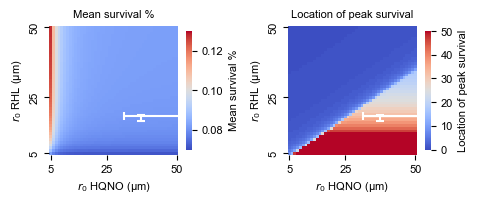

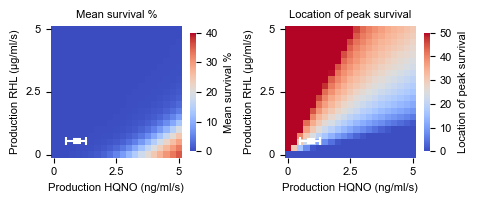

In [8]:
# fixed parameters
L = 50.0         # µm, chamber length
d = 3.0          # µm, gap length
W = 50.0         # µm, chamber width
W_gap = 12.5     # µm, gap width (0.25 * W)]

y_fit = np.linspace(0, 2*L + d, 181)
y_from_wall = y_fit - (L + d)

# Load survival parameters from JSON
SURVIVAL_JSON = Path.cwd().parent / '3_batch_survival' / 'data' / 'survival_model_parameters.json'
# Load parameters of fitted survival models
with open(SURVIVAL_JSON, "r", encoding="utf-8") as f:
    logit_model = json.load(f)
# use parameters of the 'hqno_max_60' model as this fits the empirical concentration ranges best
model_params = logit_model['hqno_max_60']['parameters']

# Load model parameters
parameter_CSV = Path.cwd().parent / '4_1D_model' / 'data' / '3_full_model_parameters.csv'
df = pd.read_csv(parameter_CSV)
cols = ['uptake rate', 'production rate', 'Deff', 'r0']

# Extract median and qunatile parameter values for both molecules
df_h = df[df['molecule'] == 'HQNO'][cols].quantile([0.25, 0.5, 0.75])
df_r = df[df['molecule'] == 'RHL'][cols].quantile([0.25, 0.5, 0.75])

r0_h_median = df_h['r0'][0.5]
r0_r_median = df_r['r0'][0.5]

prod_rate_h_median = df_h['production rate'][0.5]
prod_rate_r_median = df_r['production rate'][0.5]

prod_rate_h_error = (prod_rate_h_median - df_h['production rate'][0.25],
                     df_h['production rate'][0.75] - prod_rate_h_median)
prod_rate_r_error = (prod_rate_r_median - df_r['production rate'][0.25],
                     df_r['production rate'][0.75] - prod_rate_r_median)

r0_h_error = (r0_h_median - df_h['r0'][0.25], 
               df_h['r0'][0.75] - r0_h_median)
r0_r_error = (r0_r_median - df_r['r0'][0.25],
               df_r['r0'][0.75] - r0_r_median)

# --- Scan effects of r0_h and r0_r on survival outcomes ---
r0_scan_range = np.arange(5, 51, 1)  # interaction distances to scan over
outcomes = []

for r0h in r0_scan_range:
    for r0r in r0_scan_range:
        
        # Calculate uptake rates from interaction distances
        up_h = r0h**2 / df_h['Deff'][0.5]
        up_r = r0r**2 / df_r['Deff'][0.5]
        
        # Calculate concentration profiles using analytical solution
        conc_H = conc_curve(analytical_solution, L, d, W, W_gap, 
                            df_h['Deff'][0.5], 
                            df_h['production rate'][0.5], 
                            up_h, y_fit)
        
        conc_R = conc_curve(analytical_solution, L, d, W, W_gap, 
                            df_r['Deff'][0.5], 
                            df_r['production rate'][0.5], 
                            up_r, y_fit)
        
        # Predict survival
        survival = predict_survival(conc_H, conc_R, model_params)
        survival[y_fit < L+d] = np.nan  # set survival to nan in producer + gap region

        # Summarize outcomes
        mean_survival = np.nanmean(survival)*100  # in percentage
        peak_survival = np.nanmax(survival)*100    # in percentage
        location_max = y_from_wall[np.nanargmax(survival)]

        outcomes.append({
            '$r_0$ HQNO': r0h,
            '$r_0$ RHL': r0r,
            'mean survival %': mean_survival,
            'peak survival %': peak_survival,
            'location peak survival': location_max
        })

df_outcomes = pd.DataFrame(outcomes)

# Plot effects of r0_h and r0_r on survival outcomes

fig, axs = plt.subplots(1, 2, figsize=(12/2.5, 8/2.5))

sns.heatmap(
    df_outcomes.pivot(index='$r_0$ RHL', columns='$r_0$ HQNO', values='mean survival %'),
    ax=axs[0],
    cmap='coolwarm',
    cbar_kws={'label': 'Mean survival %', 'shrink': 0.4},
    vmin=0.07,
    vmax=0.13
)
axs[0].set_title('Mean survival %')
#axs[0].plot(r0_h_median, r0_r_median, 'wx', markersize=4, markeredgewidth=1.5)
axs[0].errorbar(r0_h_median, r0_r_median, 
                xerr=np.array(r0_h_error).reshape(2,1), 
                yerr=np.array(r0_r_error).reshape(2,1),
                ecolor='white', elinewidth=1.5, capsize=3, capthick=1.5, fmt='none')

sns.heatmap(
    df_outcomes.pivot(index='$r_0$ RHL', columns='$r_0$ HQNO', values='location peak survival'),
    ax=axs[1],
    cmap='coolwarm',
    cbar_kws={'label': 'Location of peak survival', 'shrink': 0.4},
    vmin=0,
    vmax=50
)
axs[1].set_title('Location of peak survival')
#axs[1].plot(r0_h_median, r0_r_median, 'wx', markersize=4, markeredgewidth=1.5)
axs[1].errorbar(r0_h_median, r0_r_median, 
                xerr=np.array(r0_h_error).reshape(2,1), 
                yerr=np.array(r0_r_error).reshape(2,1),
                ecolor='white', elinewidth=1.5, capsize=3, capthick=1.5, fmt='none')

# Set x and y ticks only at 5, 25, and 50 µm
tick_vals = [5, 25, 50]
cols = sorted(df_outcomes['$r_0$ HQNO'].unique().tolist())
rows = sorted(df_outcomes['$r_0$ RHL'].unique().tolist())
xpos = [cols.index(v) + 0.5 for v in tick_vals if v in cols]
ypos = [rows.index(v) + 0.5 for v in tick_vals if v in rows]
for ax in axs:
    ax.set_xticks(xpos)
    ax.set_xticklabels([str(v) for v in tick_vals])
    ax.set_yticks(ypos)
    ax.set_yticklabels([str(v) for v in tick_vals])
    ax.invert_yaxis()
    ax.set_ylabel('$r_0$ RHL (µm)')
    ax.set_xlabel('$r_0$ HQNO (µm)')    
    ax.set_aspect('equal')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(Path.cwd() / 'figures' / '4_model_parameter_scan_interaction_range.pdf', dpi=300)

# --- Scan effects of production on survival outcomes ---
prod_scan_range = np.arange(0, 5.2, 0.25)  # interaction distances to scan over
outcomes = []

for prod_h in prod_scan_range:
    for prod_r in prod_scan_range:
        
        # Calculate concentration profiles using analytical solution
        conc_H = conc_curve(analytical_solution, L, d, W, W_gap, 
                            df_h['Deff'][0.5], 
                            prod_h, 
                            df_h['uptake rate'][0.5], 
                            y_fit)
        
        conc_R = conc_curve(analytical_solution, L, d, W, W_gap, 
                            df_r['Deff'][0.5], 
                            prod_r, 
                            df_r['uptake rate'][0.5], 
                            y_fit)
        
        # Predict survival
        survival = predict_survival(conc_H, conc_R, model_params)
        survival[y_fit < L+d] = np.nan  # set survival to nan in producer + gap region

        # Summarize outcomes
        mean_survival = np.nanmean(survival)*100  # in percentage
        peak_survival = np.nanmax(survival)*100    # in percentage
        location_max = y_from_wall[np.nanargmax(survival)]

        outcomes.append({
            'Production HQNO': prod_h,
            'Production RHL': prod_r,
            'mean survival %': mean_survival,
            'peak survival %': peak_survival,
            'location peak survival': location_max
        })

df_outcomes = pd.DataFrame(outcomes)

# Plot effects of production on survival outcomes

fig, axs = plt.subplots(1, 2, figsize=(12/2.5, 8/2.5))

sns.heatmap(
    df_outcomes.pivot(index='Production RHL', columns='Production HQNO', values='mean survival %'),
    ax=axs[0],
    cmap='coolwarm',
    cbar_kws={'label': 'Mean survival %', 'shrink': 0.4},
    vmin=0,
    vmax=40
)
axs[0].set_title('Mean survival %')
#axs[0].plot(prod_rate_h_median, prod_rate_r_median, 'wx', markersize=4, markeredgewidth=1.5)
axs[0].errorbar(prod_rate_h_median, prod_rate_r_median, 
                xerr=np.array(prod_rate_h_error).reshape(2,1), 
                yerr=np.array(prod_rate_r_error).reshape(2,1),
                ecolor='white', elinewidth=1.5, capsize=3, capthick=1.5, fmt='none')

sns.heatmap(
    df_outcomes.pivot(index='Production RHL', columns='Production HQNO', values='location peak survival'),
    ax=axs[1],
    cmap='coolwarm',
    cbar_kws={'label': 'Location of peak survival', 'shrink': 0.4},
    vmin=0,
    vmax=50
)
axs[1].set_title('Location of peak survival')
axs[1].errorbar(prod_rate_h_median, prod_rate_r_median, 
                xerr=np.array(prod_rate_h_error).reshape(2,1), 
                yerr=np.array(prod_rate_r_error).reshape(2,1),
                ecolor='white', elinewidth=1.5, capsize=3, capthick=1.5, fmt='none')

# Set x and y ticks
tick_vals = [0, 2.5, 5]
cols = sorted(df_outcomes['Production HQNO'].unique().tolist())
rows = sorted(df_outcomes['Production RHL'].unique().tolist())
xpos = [cols.index(v) + 0.5 for v in tick_vals if v in cols]
ypos = [rows.index(v) + 0.5 for v in tick_vals if v in rows]
for ax in axs:
    ax.set_xticks(xpos)
    ax.set_xticklabels([str(v) for v in tick_vals])
    ax.set_yticks(ypos)
    ax.set_yticklabels([str(v) for v in tick_vals])
    ax.invert_yaxis()
    ax.set_ylabel('Production RHL (µg/ml/s)')
    ax.set_xlabel('Production HQNO (ng/ml/s)')    
    ax.set_aspect('equal')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(Path.cwd() / 'figures' / '4_model_parameter_scan_production_rate.pdf', dpi=300)